# Mapping mouse coronal snRNA-seq cell type to 10X Visium

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load cell type expression signatures programmes](#Loading_signatures)
* [Run cell2location](#cell2location)
* [Region clustering cell densities](#region_clustering)
* [Export regions for import to 10X Loupe Browser](#loupe)
* [Run diffusion maps](#diffmap)
* [Run factorisation to find groups of cell types with similar location](#factorisation)


### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
#from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
#os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

#import cell2location
import scvi
#import pycell2location.models as c2l

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [47]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/regression_model/'

scvi_run_name = f'{results_folder}signatures_v3_lr0002_Adam'
scvi_ref_run_name = f'{sc_results_folder}signatures_v0_Adam_lr0002_ref'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')

In [3]:
sample_data

sample_name sample_name2                                         image_name  \
0   ST8059048   Visium-28C  mouse_brain_he_Library_028_C05717_020_C1_14460...   
1   ST8059049   Visium-28D  mouse_brain_he_Library_028_C05717_020_D1_14460...   
2   ST8059050   Visium-28E  mouse_brain_he_Library_028_C05717_020_E1_14460...   
3   ST8059051   Visium-29B  mouse_brain_he_Library_029_C05717_021_B1_14460...   
4   ST8059052   Visium-29C  mouse_brain_he_Library_029_C05717_021_C1_14460...   

        slide position  
0  C05717-020       C1  
1  C05717-020       D1  
2  C05717-020       E1  
3  C05717-021       B1  
4  C05717-021       C1

Next we load the mRNA count for each Visium slide and corresponding histology images as a list `slides` and as a single anndata object `adata`. We need this redundancy because scanpy plotting over the histology image does not work with multiple sections.   

In [4]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    
    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # for spatial mapping remove MT genes
    adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
    adata = adata[:, ~adata.var['mt'].values]
    
    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata

# read first sample
adata = read_and_qc(sample_data['sample_name'][0],
                    path=sp_data_folder + 'rawdata/') 

# read the remaining samples
slides = {}
for i in sample_data['sample_name'][1:]:
    adata_1 = read_and_qc(i, path=sp_data_folder + 'rawdata/') 
    slides[str(i)] = adata_1

adata_0 = adata.copy()
    
# combine individual samples
#adata = adata.concatenate(list(slides.values()), index_unique=None)
adata = adata.concatenate(
    list(slides.values()),
    batch_key="sample",
    uns_merge="unique",
    batch_categories=list(sample_data['sample_name'].values), 
    index_unique=None
)

obs = adata.obs.merge(sample_data, left_on='sample', right_on='sample_name')
obs.index = adata.obs_names
adata.obs = obs

slides[str(sample_data['sample_name'][0])] = adata_0

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call 

Now let's look at QC: total number of counts and total number of genes per spot

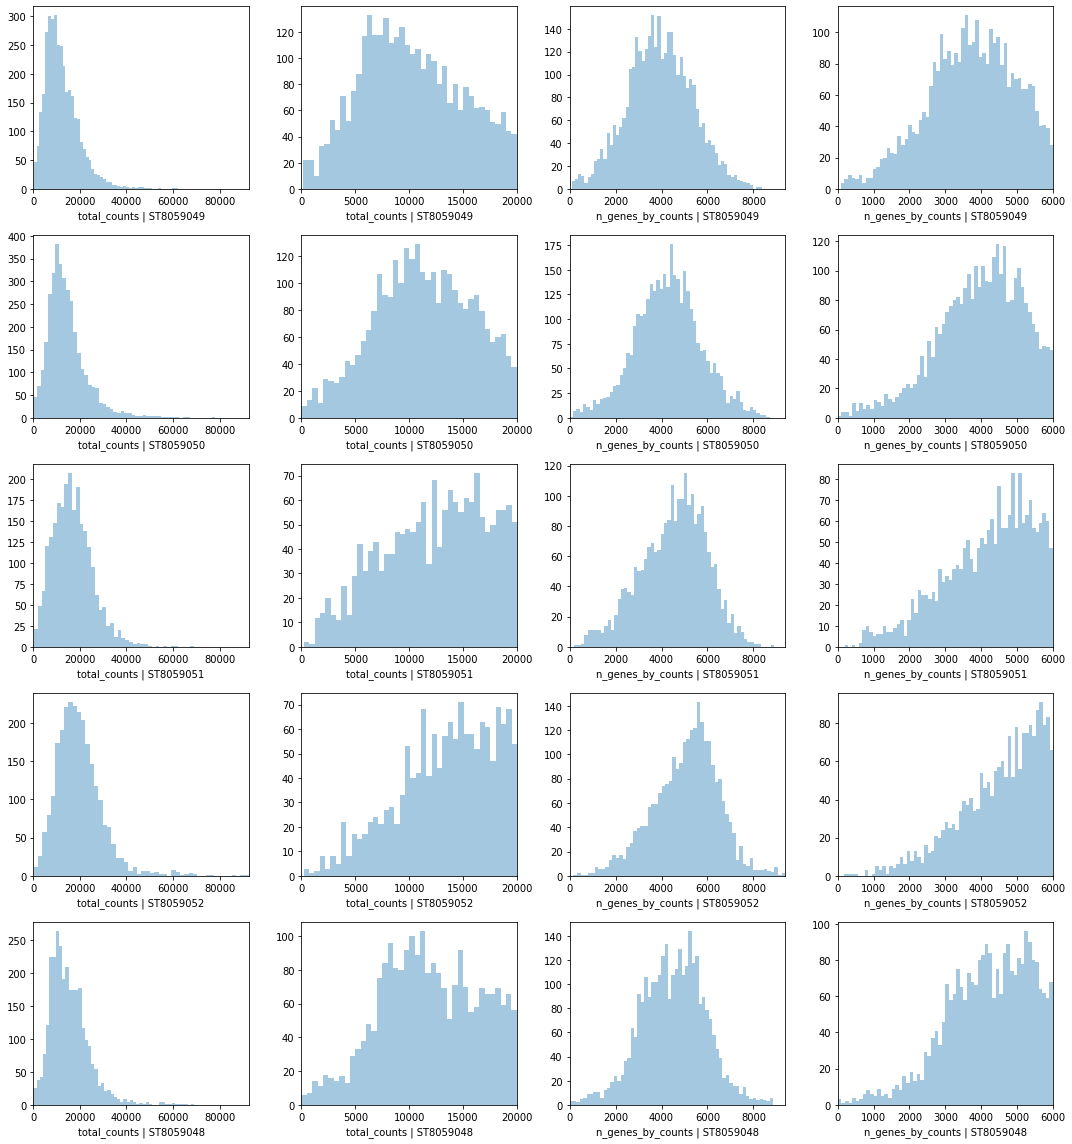

In [5]:
# PLOT QC FOR EACH SAMPLE 
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i in range(len(slides)):
    #fig.suptitle('Covariates for filtering')
    
    sns.distplot(list(slides.values())[i].obs['total_counts'], 
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['total_counts']\
                 [list(slides.values())[i].obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel('total_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
    sns.distplot(list(slides.values())[i].obs['n_genes_by_counts']\
                 [list(slides.values())[i].obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel('n_genes_by_counts | ' + list(slides.keys())[i])
    
plt.tight_layout()

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


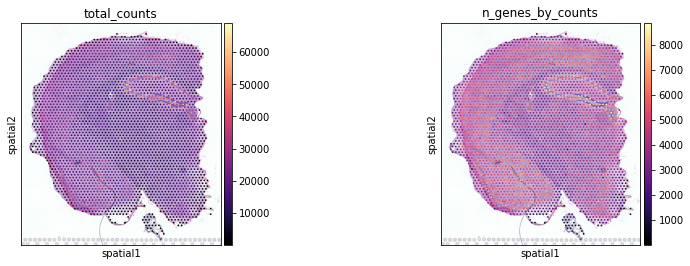

In [6]:
sc.pl.spatial(slides['ST8059048'], img_key = "hires", cmap='magma',
              color=['total_counts', 'n_genes_by_counts'],
              gene_symbols='SYMBOL', size=0.8)

Here we show how to use scanpy to plot results over histology section using anndata object from one section, and 

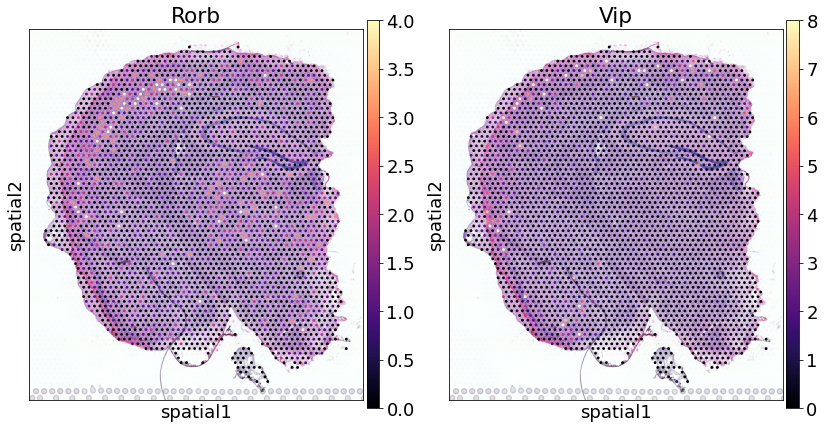

In [7]:
rcParams["axes.facecolor"] = "white"
rcParams["figure.figsize"] = [6,7]
rcParams["font.size"] = 18

sc.pl.spatial(slides['ST8059048'], 
              color=["Rorb", "Vip"], img_key='hires',
              vmin=0, cmap='magma', vmax='p99.0',
              gene_symbols='SYMBOL', size=0.8
             )

In [8]:
adata.raw = adata

### Load cell type expression signatures programmes <a class="anchor" id="Loading_signatures"></a>

In [9]:
reg_mod_name = 'RegressionNBV2Torch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
adata_snrna_raw.X = adata_snrna_raw.raw.X.copy()
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']

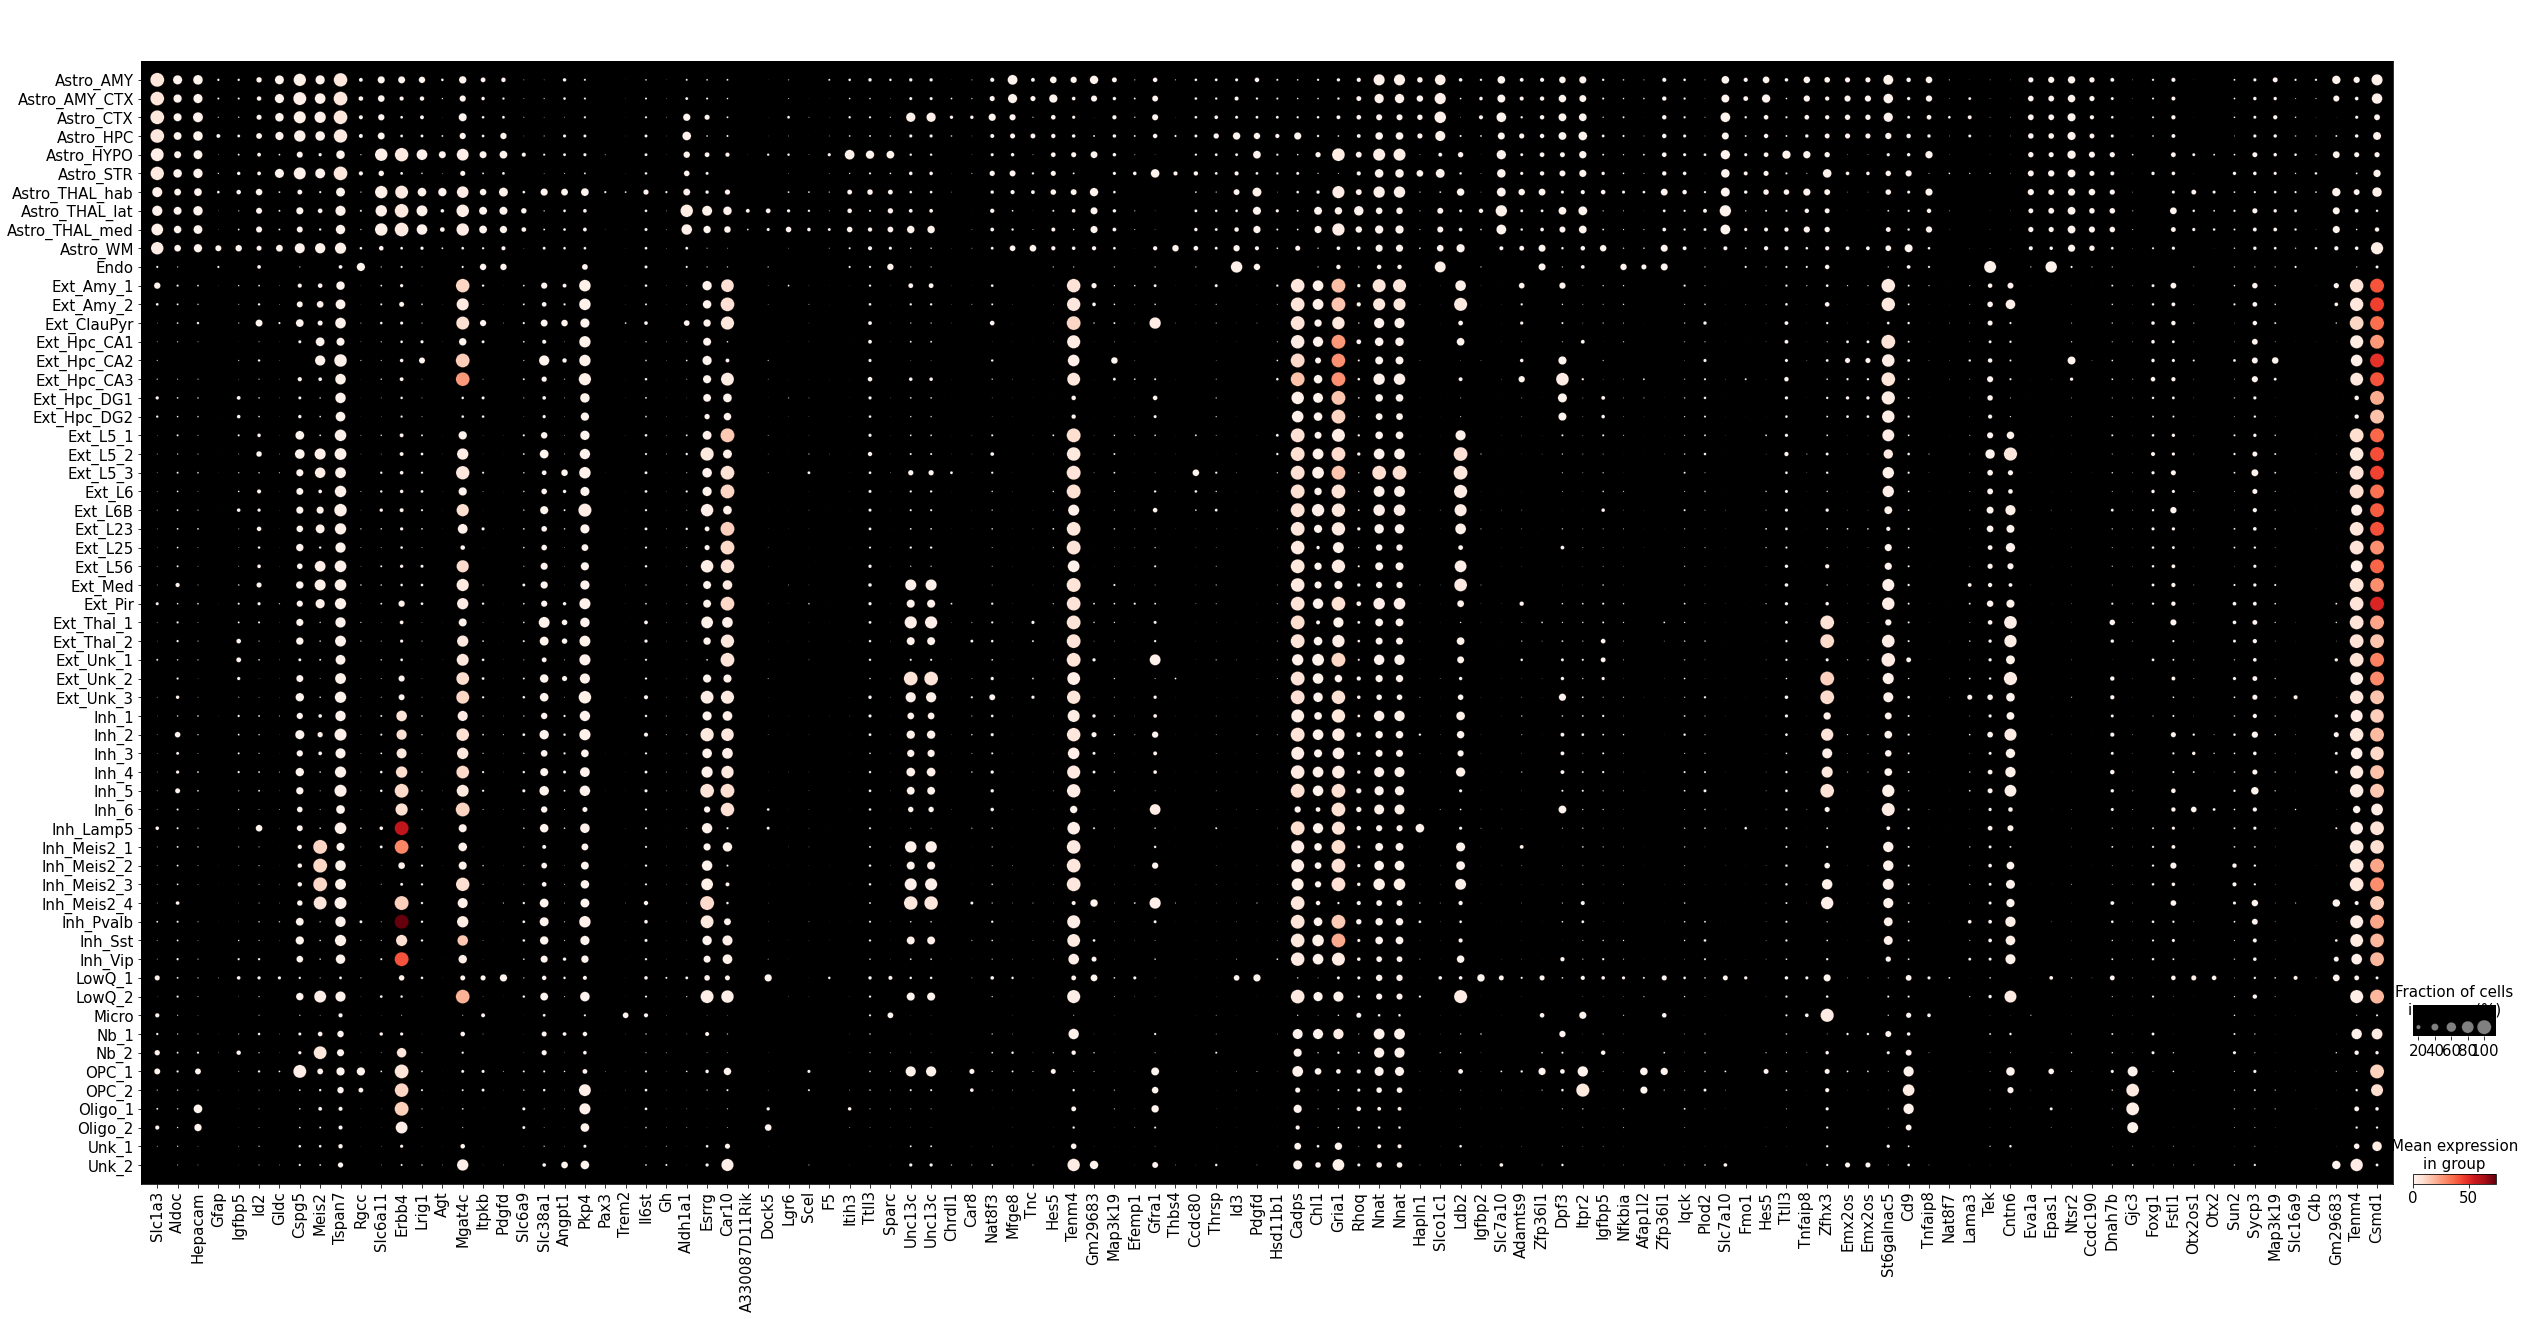

In [10]:
#sc_figpath = sc.settings.figdir
#sc.settings.figdir = f'{reg_path}marker_plots/'

gene_list = pd.read_csv(f'{reg_path}figures/Subtype_markers.csv', header=0)['Genes']
with matplotlib.rc_context({'axes.facecolor':  'black'}):
    sc.pl.dotplot(adata_snrna_raw, gene_list, groupby='annotation_1', 
                  gene_symbols='SYMBOL', use_raw=False, 
                  #save=f'selected_panel.pdf', 
                  show=True);
#sc.settings.figdir = sc_figpath

In [11]:
# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_snrna_raw, batch_key='sample', labels_key='annotation_1'
                       )
scvi.data.view_anndata_setup(adata_snrna_raw)

INFO     Using batches from adata.obs["sample"]                                              
INFO     Using labels from adata.obs["annotation_1"]                                         
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 40532 cells, 12819 vars, 6        
         batches, 59 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [21:33<00:00,  5.17s/it, v_num=1, elbo_train=2.53e+8]


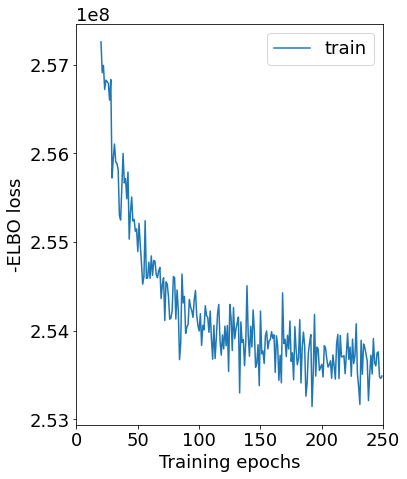

In [12]:
# create and train the model
from scvi.external.cell2location._reference_module import RegressionModel
import pyro
mod = RegressionModel(
    adata_snrna_raw,
    #amortised=True, encoder_mode="single",
    #encoder_kwargs={'dropout_rate': 0.1},
    #init_vals = {'per_cluster_mu_fg': per_cluster_mu_fg}
) 

mod.train(max_epochs=250, 
          batch_size=2500, 
          train_size=1,
          #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002, 'clip_norm': 10})},
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [13]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_snrna_raw = mod.export_posterior(
    adata_snrna_raw, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_ref_run_name}", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_ref_run_name}", adata_snrna_raw)

# Save anndata object with results
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:23<00:00, 43.22it/s]


'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/regression_model/signatures_v0_Adam_lr0002_ref/sc.h5ad'

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

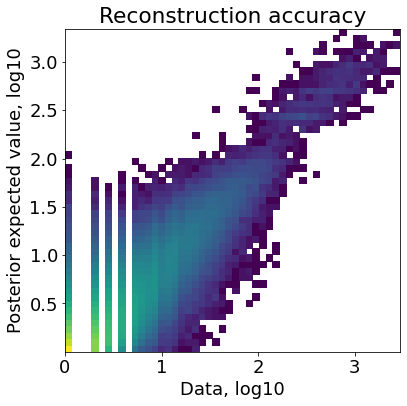

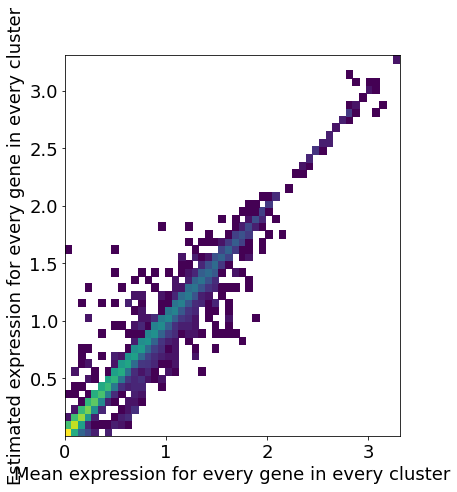

In [14]:
mod.plot_QC()

In [12]:
#mod = scvi.external.cell2location.RegressionModel.load(f"{scvi_run_name}_ref/", adata_snrna_raw)
adata_file = f"{scvi_ref_run_name}/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

In [13]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Astro_AMY  Astro_AMY_CTX  Astro_CTX  Astro_HPC  Astro_HYPO
ENSEMBL                                                                       
ENSMUSG00000051951   0.040710       0.079320   0.057454   0.059812    0.084526
ENSMUSG00000089699   0.004963       0.006407   0.009193   0.007305    0.016441
ENSMUSG00000033845   0.112017       0.054752   0.094273   0.067388    0.081231
ENSMUSG00000033813   0.093426       0.106448   0.136787   0.096871    0.091096
ENSMUSG00000002459   3.554433       4.124567   4.123194   3.952404    1.159038

### Run cell2location <a class="anchor" id="cell2location"></a>

Here we show how to perform the first step in one function run - train cell2location model to learn cell locations. Results are shown below and saved to:  

In [14]:
results_folder + 'scvi/'

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/'

In [15]:
adata_vis = adata.copy()

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14968 cells, 12809 vars, 5        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20000/20000: 100%|██████████| 20000/20000 [1:51:15<00:00,  3.00it/s, v_num=1, elbo_train=1.52e+8]


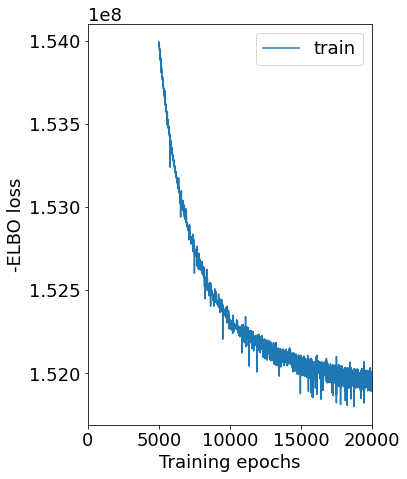

In [16]:
batch_size = None
amortised = False
max_epochs = 20000

import torch.nn as nn
import pyro

# create and train the model
from scvi.external.cell2location._cell2location_v2_module import LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlphaPyroModel
mod = scvi.external.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    model_class=LocationModelLinearDependentWMultiExperimentLocationBackgroundNormGeneAlphaPyroModel,
    amortised=amortised, #single_encoder=True,
    encoder_kwargs={'dropout_rate': 0.1,
                    'use_batch_norm': False, 'use_layer_norm': True, 
                    'n_layers': 1, 'activation_fn': nn.LeakyReLU},
    # the expected average cell abundance - user-provided, tissue-dependent hyper-prior:
    N_cells_per_location=8) 

mod.train(max_epochs=max_epochs, 
          batch_size=batch_size, 
          train_size=1,
          #lr=0.005,
          #plan_kwargs={'optim': pyro.optim.ClippedAdam(optim_args={'lr': 0.002,
          #                                                         'clip_norm': 10})},
          plan_kwargs={'optim': pyro.optim.Adam(optim_args={'lr': 0.002})},
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(5000)
#plt.legend(labels=['minibatch 2500/14968']);

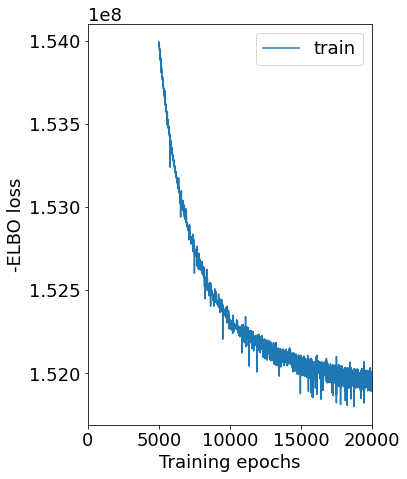

In [17]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(5000)
#plt.legend(labels=['minibatch 2500/14968']);

In [18]:
mod.module.guide

AutoNormal(
  (locs): PyroModule()
  (scales): PyroModule()
)

In [19]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 100, 'batch_size':  mod.adata.n_obs, 'use_gpu': True}
)

Sampling global variables, sample: 100%|██████████| 99/99 [00:05<00:00, 17.95it/s]


... storing 'sample' as categorical
... storing 'sample_name' as categorical
... storing 'sample_name2' as categorical
... storing 'image_name' as categorical
... storing 'slide' as categorical
... storing 'position' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical


'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/scvi/Cell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/signatures_v3_lr0002_Adam_c2l//sp.h5ad'

In [49]:
# Save model
run_name = f'{mod.__class__.__name__}_{mod.summary_stats["n_batch"]}experiments_{mod.n_factors_}clusters_{mod.summary_stats["n_cells"]}locations_{mod.summary_stats["n_vars"]}genes_{batch_size}batch_size_amortised{amortised}_{max_epochs}max_epochs'
scvi_run_name = f'{scvi_run_name}{run_name}_c2l/'

mod.save(f"{scvi_run_name}", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

... storing 'image_name_i' as categorical


'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/signatures_v3_lr0002_AdamCell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_c2l//sp.h5ad'

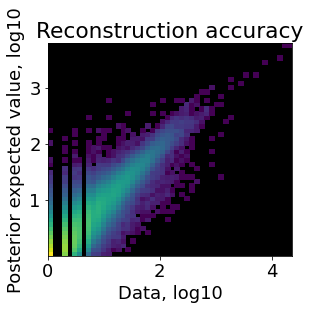

In [50]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [51]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


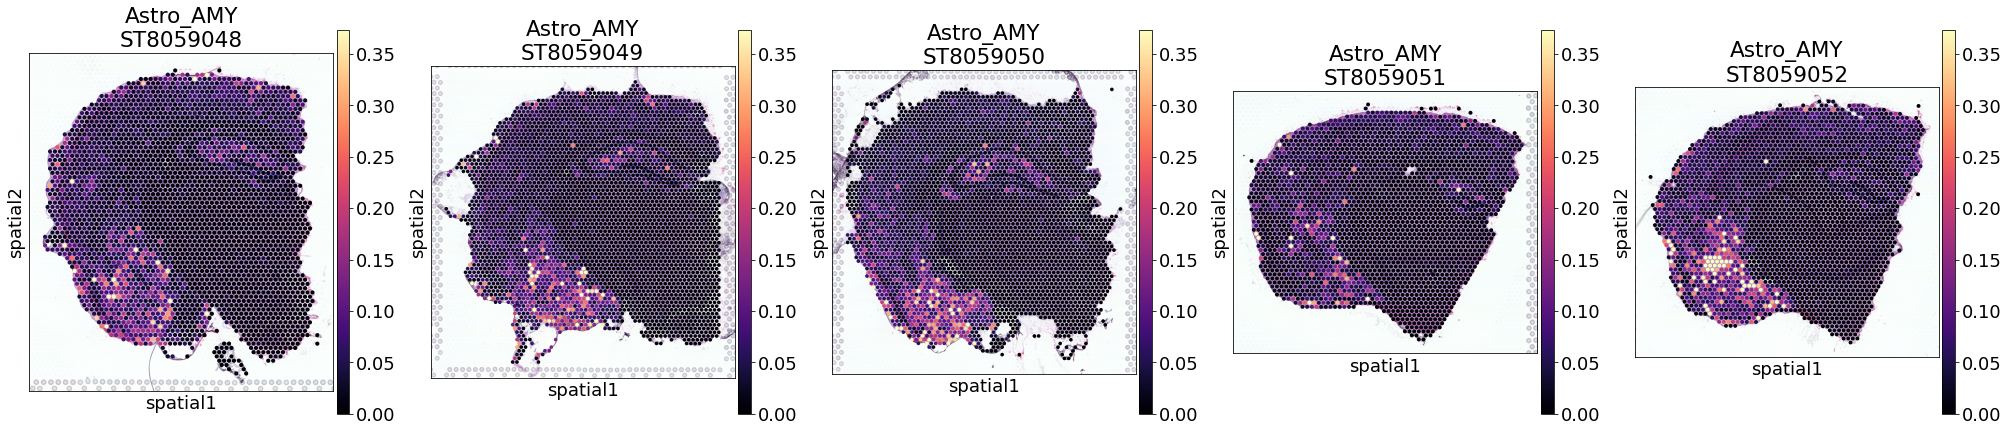

In [52]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y

def plot_spatial_per_cell_type(adata, 
                               cell_type=adata_vis.uns['mod']['factor_names'][0],
                               samples=adata_vis.obs['sample'].unique(),
                              ncol=5):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(28, 6))
    if nrow == 1:
        axs = axs.reshape((1, ncol))
    
    col_name = f'{cell_type}'
    vmax = np.quantile(adata.obs[col_name].values, 0.992)
    adata.obs[cell_type] = adata.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        sp_data_s = select_slide(adata, s, s_col='sample')
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      size=1.3, img_key='hires', alpha_img=1,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                            )
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
        
    if len(samples) < len(axs.flatten()):
        for i in range(len(samples), len(axs.flatten())):
            axs[ind[i][0],ind[i][1]].axis('off')
        
    fig.tight_layout(pad=0.5)
        
    return fig

plot_spatial_per_cell_type(adata_vis, cell_type=adata_vis.uns['mod']['factor_names'][0]);

In [53]:
from re import sub
import os
for c in adata_vis.uns['mod']['factor_names']:
    fig = plot_spatial_per_cell_type(adata_vis, cell_type=c)
    fig_dir = f"{scvi_run_name}/spatial/"
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    fig_dir = f"{scvi_run_name}/spatial/per_cell_type/"
    if not os.path.exists(fig_dir):
        os.mkdir(fig_dir)
    fig.savefig(f"{fig_dir}W_cell_abundance_q05_{sub('/', '_', c)}.png",
                bbox_inches='tight')
    fig.clear()
    plt.close(fig)

f"{scvi_run_name}/spatial/per_cell_type/"


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attrib

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attrib

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/signatures_v3_lr0002_AdamCell2location_5experiments_59clusters_14968locations_12809genes_Nonebatch_size_amortisedFalse_20000max_epochs_c2l//spatial/per_cell_type/'

In [54]:
with matplotlib.rc_context({"axes.facecolor": "black"}):
    clust_names = adata_vis.uns['mod']['factor_names']
    
    for s in adata_vis.obs['sample'].unique():

        s_ind = adata_vis.obs['sample'] == s
        s_keys = list(adata_vis.uns['spatial'].keys())
        s_spatial = np.array(s_keys)[[s in i for i in s_keys]][0]

        fig = sc.pl.spatial(adata_vis[s_ind, :], cmap='magma',
                            color=clust_names, ncols=5, library_id=s_spatial,
                            size=1.3, img_key='hires', alpha_img=1,
                            vmin=0, vmax='p99.2',
                            return_fig=True, show=False)
        
        fig_dir = f"{scvi_run_name}/spatial/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)
        fig_dir = f"{scvi_run_name}/spatial/per_sample/"
        if not os.path.exists(fig_dir):
            os.mkdir(fig_dir)

        plt.savefig(f"{fig_dir}W_cell_abundance_q05_{s}.png",
                    bbox_inches='tight')
        plt.close()

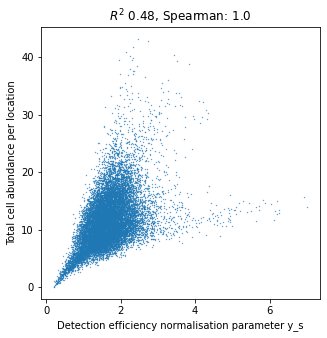

In [55]:
# compare this parameter to nUMI 
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 10, 
                            'figure.figsize': [5, 5]}):
    detection_eff_y_s = adata_vis.uns['mod']['post_sample_means']['detection_y_s'].flatten()
    total_cell_abundance = adata_vis.uns['mod']['post_sample_means']['w_sf'].sum(1)
    cor = np.corrcoef(detection_eff_y_s, total_cell_abundance)[0, 1]
    from scipy.stats import spearmanr
    cor_spearmanr = spearmanr(detection_eff_y_s, detection_eff_y_s)
    
    plt.scatter(detection_eff_y_s, total_cell_abundance,
                s=0.1);
    plt.xlabel('Detection efficiency normalisation parameter y_s');
    plt.ylabel('Total cell abundance per location');
    plt.title(f'$R^2$ {np.round(cor, 2)}, Spearman: {np.round(np.array(cor_spearmanr)[0], 2)}')

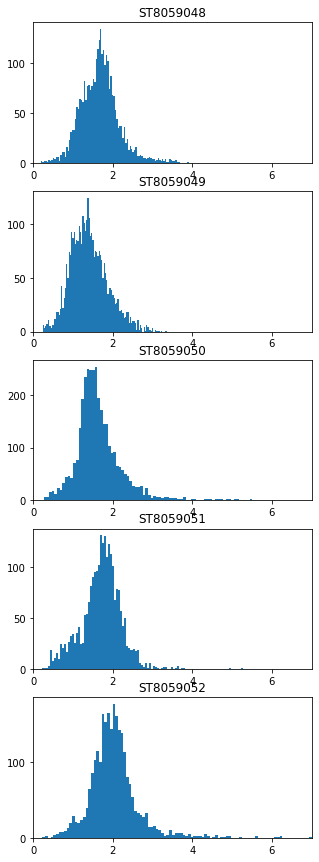

In [56]:
# look at the location detection efficiency parameter for each experiment
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 10, 
                            'figure.figsize': [5, 15]}):
    for i, n in enumerate(adata_vis.obs['sample'].unique()):
        plt.subplot(len(adata_vis.obs['sample'].unique()), 1, i+1)
        x = adata_vis.uns['mod']['post_sample_means']['detection_y_s'].flatten()
        x = x[adata_vis.obs['sample'] == n]
        plt.hist(x, bins=100);
        plt.title(n)
        plt.xlim(0, adata_vis.uns['mod']['post_sample_means']['detection_y_s'].max())

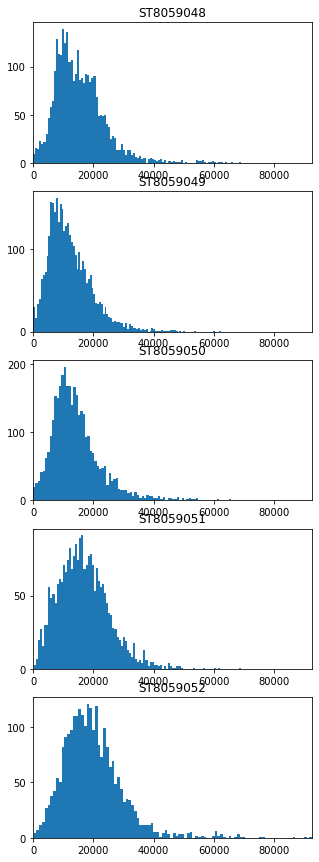

In [57]:
# look at the location detection efficiency parameter for each experiment
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 10, 
                            'figure.figsize': [5, 15]}):
    for i, n in enumerate(adata_vis.obs['sample'].unique()):
        plt.subplot(len(adata_vis.obs['sample'].unique()), 1, i+1)
        x = adata_vis.obs['total_counts'].values.flatten()
        x = x[adata_vis.obs['sample'] == n]
        plt.hist(x, bins=100);
        plt.title(n)
        plt.xlim(0, adata_vis.obs['total_counts'].values.max())

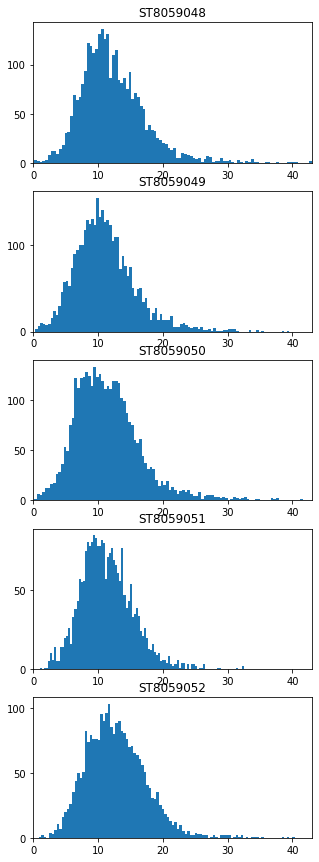

In [58]:
# look at the total cell abundance for each experiment
with matplotlib.rc_context({'axes.facecolor': 'white', 'font.size': 10, 
                            'figure.figsize': [5, 15]}):
    for i, n in enumerate(adata_vis.obs['sample'].unique()):
        plt.subplot(len(adata_vis.obs['sample'].unique()), 1, i+1)
        total_cell_abundance = adata_vis.uns['mod']['post_sample_means']['w_sf'].sum(1).flatten()
        total_cell_abundance_ = total_cell_abundance[adata_vis.obs['sample'] == n]
        plt.hist(total_cell_abundance_, bins=100);
        plt.title(n)
        plt.xlim(0, total_cell_abundance.max())

In [59]:
#adata_vis.uns['mod']['post_sample_means']['m_g_mean'], 
adata_vis.uns['mod']['post_sample_means']['m_g'].mean()

0.20629771071979716

## Compare to mapping with the regression model using R^2

In [60]:
run_regression = 'LocationModelLinearDependentWMultiExperiment_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'
sp_data_file_regression = results_folder +run_regression+'/sp.h5ad'
adata_vis_regression = anndata.read(sp_data_file_regression)

In [61]:
np.all(adata_vis_regression.uns['mod']['obs_names'] == adata_vis.uns['mod']['obs_names'])

True

In [62]:
fig_path = scvi_run_name+'figures/'

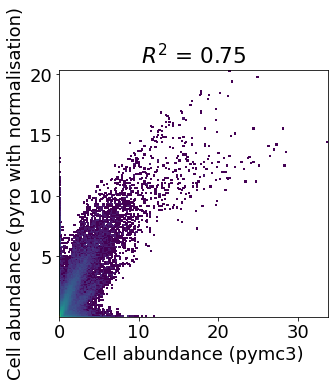

In [63]:
with matplotlib.rc_context({"figure.figsize": (5,5),
                            "axes.facecolor": "white"}):
    r = np.corrcoef(adata_vis_regression.uns['mod']['post_sample_q05']['spot_factors'].flatten(),
                    adata_vis.uns['mod']['post_sample_q05']['w_sf'].flatten())[0,1]
    
    plt.hist2d(adata_vis_regression.uns['mod']['post_sample_q05']['spot_factors'].flatten(),
                    adata_vis.uns['mod']['post_sample_q05']['w_sf'].flatten(),
               bins=200, norm=matplotlib.colors.LogNorm());
    plt.xlabel('Cell abundance (pymc3)');
    plt.ylabel('Cell abundance (pyro with normalisation)');
    plt.title(r'$R^2$ = ' + f'{np.round(r, 3)}')
    plt.tight_layout()
    #plt.savefig(f'{fig_path}pyro_vs_pymc3.pdf',
    #            bbox_inches='tight', facecolor='white')
    plt.show()

## Region clustering cell densities <a class="anchor" id="region_clustering"></a>

We find regions by clustering spots based on inferred molecule contributions of each cell type. We use leiden clustering that incorporates both the similarity of spots in cell locations and in their proximity, by including both when computing the KNN graph. Results are saved in `adata_vis.obs['leiden']`.

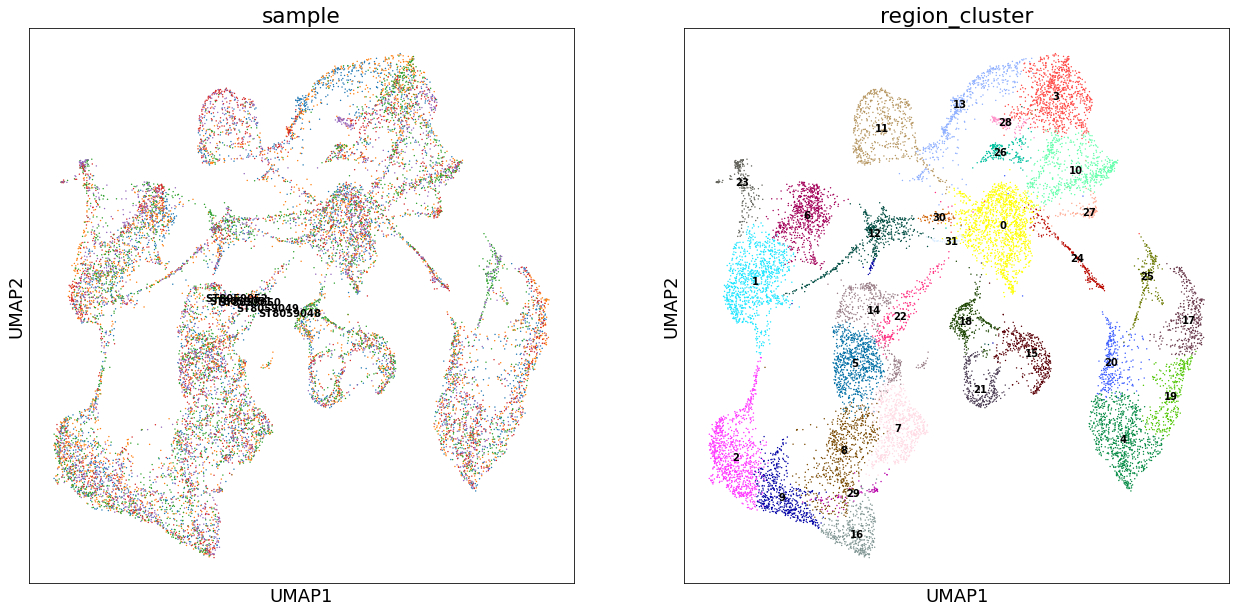

Trying to set attribute `.uns` of view, copying.


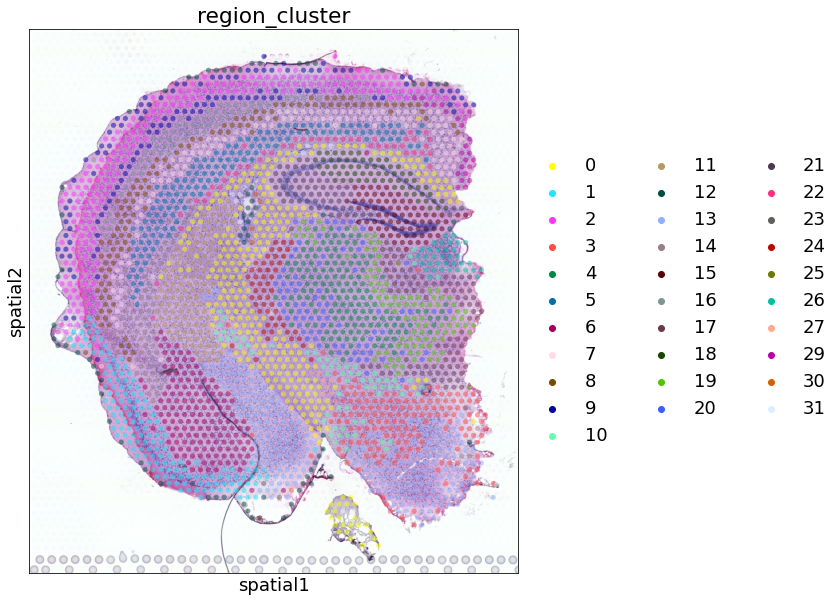

Trying to set attribute `.uns` of view, copying.


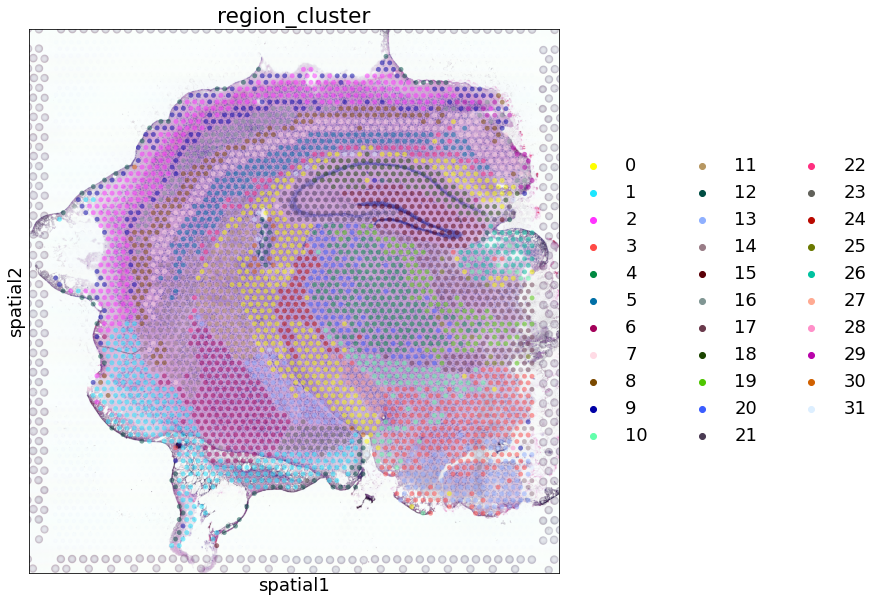

Trying to set attribute `.uns` of view, copying.


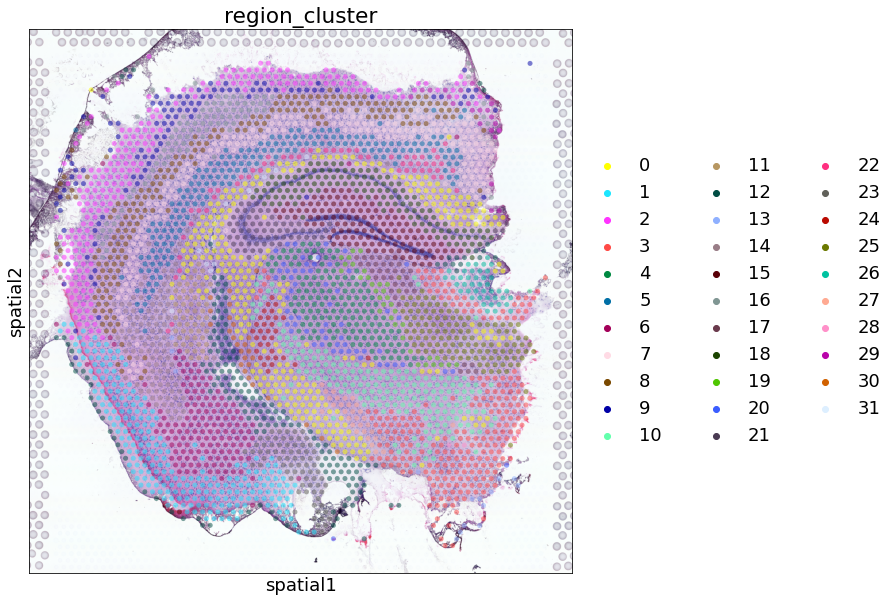

Trying to set attribute `.uns` of view, copying.


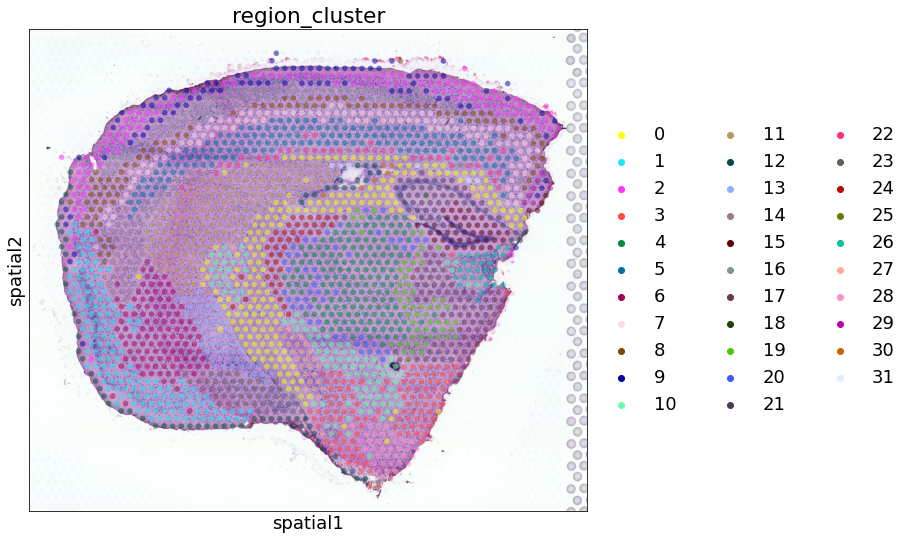

Trying to set attribute `.uns` of view, copying.


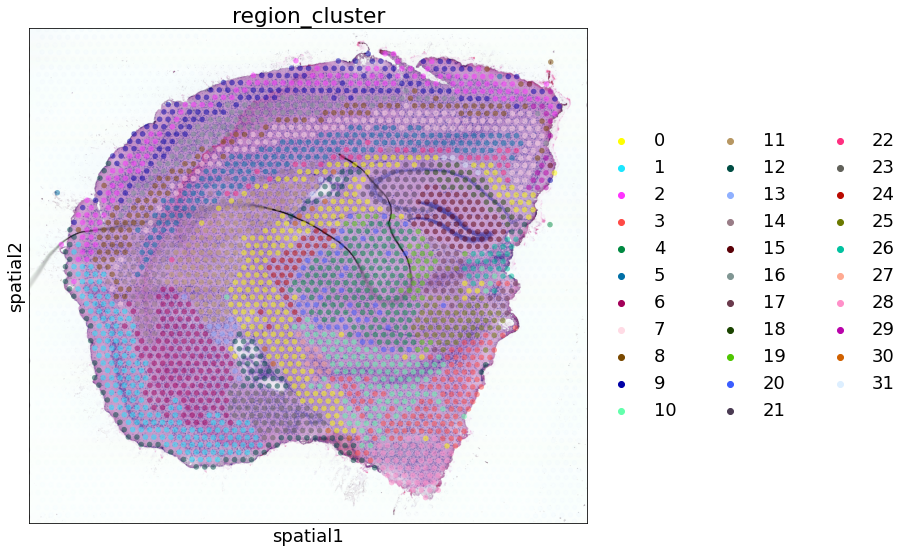

In [64]:
sample_type = 'q05_cell_abundance_w_sf'

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 38, metric='correlation')

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.3)

adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] = adata_vis.obs["region_cluster"].astype("category")

# Next we show these regions in a UMAP based on cell densities
sc.tl.umap(adata_vis)

rcParams['figure.figsize'] = 10, 10
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_vis, color=['sample', 'region_cluster'],
           color_map = 'RdPu', ncols = 2, legend_loc='on data',
           legend_fontsize=10)

# Plot locations of clusters
rcParams["figure.figsize"] = [10, 10]
rcParams["axes.facecolor"] = "white"

for s in list(adata_vis.obs["sample"].unique()):
    slide = select_slide(adata_vis, s)
    sc.pl.spatial(slide, alpha=0.5,
                  color=["region_cluster"], img_key='hires', size=1,
                  #color_map=matplotlib.cm.get_cmap('Spectral')
                );

### Export regions for import to 10X Loupe Browser
# add binary labels for each region
region_cluster_bin = adata_vis.obs[['region_cluster']]
# save maps for each sample separately
sam = np.array(adata_vis.obs['sample'])

for i in np.unique(sam):
    
    s1 = region_cluster_bin
    s1 = s1.loc[sam == i]
    s1.index = [x[10:] for x in s1.index]
    s1.index.name = 'Barcode'
    
    s1.to_csv(scvi_run_name+''\
               +'/region_cluster29_' + i + '.csv')

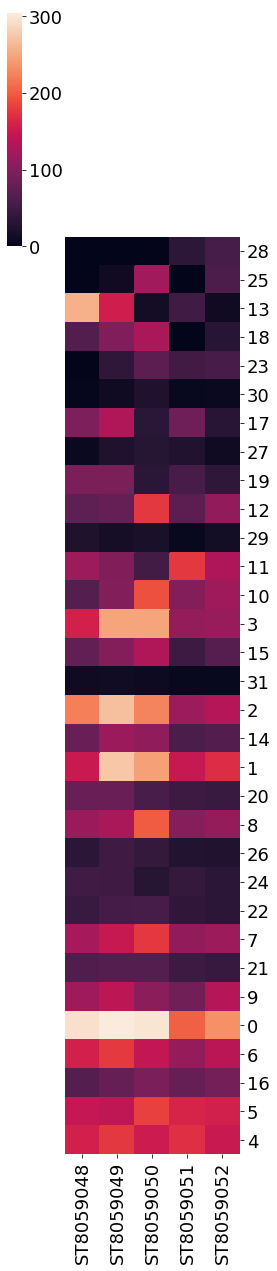

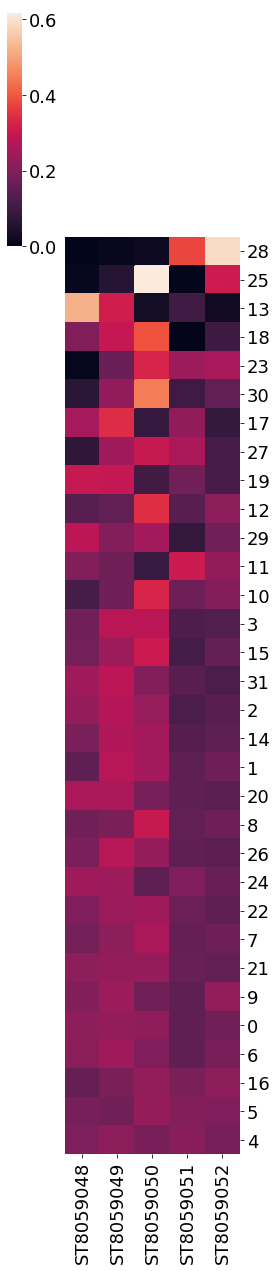

In [65]:
# check which clusters are in which section

def count_locations(adata, sample, cluster):
    
    return (adata.obs['sample'].isin([sample]) & adata.obs['region_cluster'].isin([cluster])).sum()
    
count_mat = [[count_locations(adata_vis, i, j) 
              for i in adata_vis.obs['sample'].unique()]
             for j in adata_vis.obs['region_cluster'].unique()]
count_df = pd.DataFrame(count_mat, index=adata_vis.obs['region_cluster'].unique(), 
                        columns=adata_vis.obs['sample'].unique())
count_fraq_df = (count_df.T / count_df.sum(1)).T

from scipy.stats import entropy
count_ent = entropy(count_fraq_df, base=2, axis=1)
count_df = count_df.iloc[np.argsort(count_ent),:]
count_fraq_df = count_fraq_df.iloc[np.argsort(count_ent),:]

from seaborn import clustermap
clustermap(count_df, figsize=[4, 18], row_cluster=False, col_cluster=False)
clustermap(count_fraq_df, figsize=[4, 18], row_cluster=False, col_cluster=False)

### Which cell types does the model consider co-located?

Trying to set attribute `.uns` of view, copying.


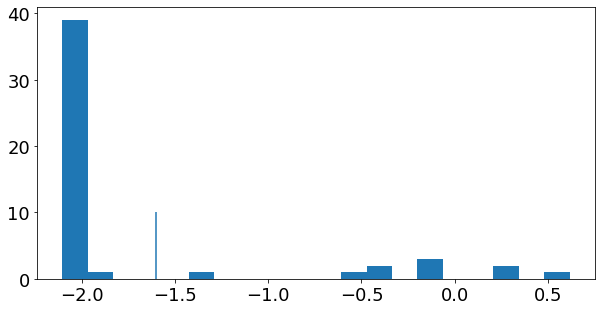

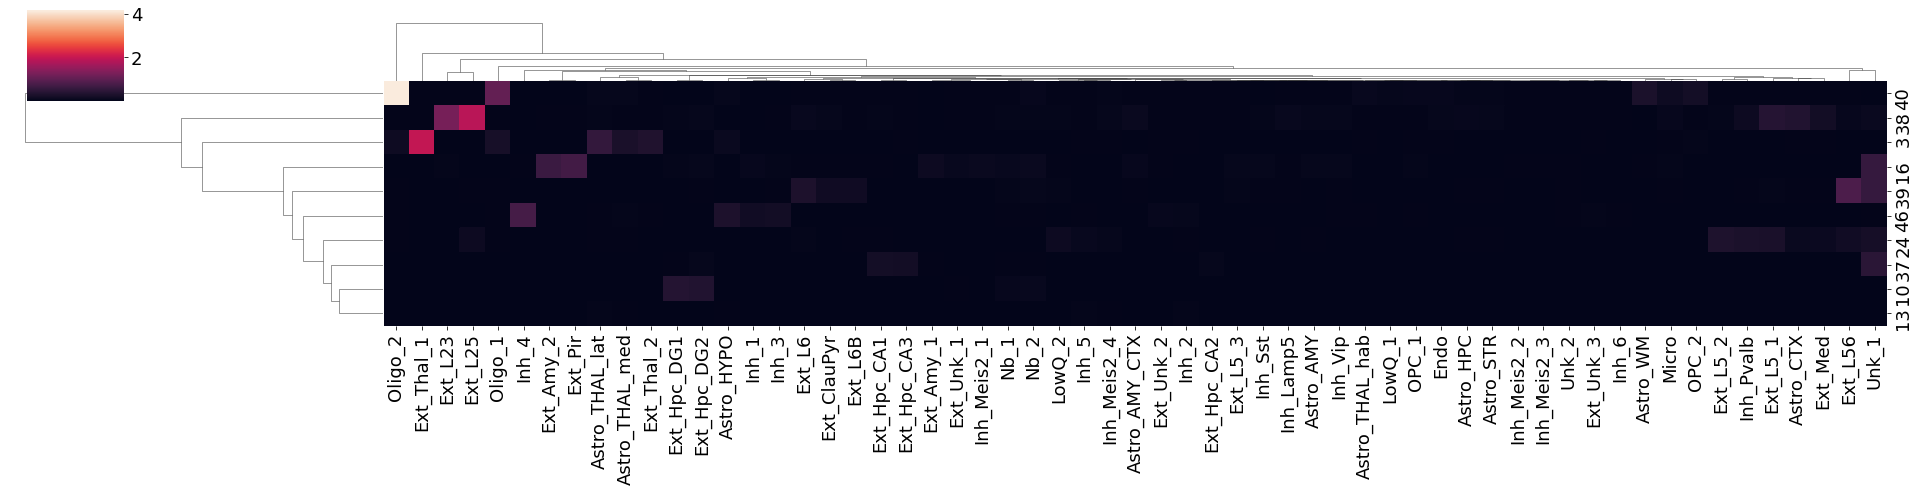

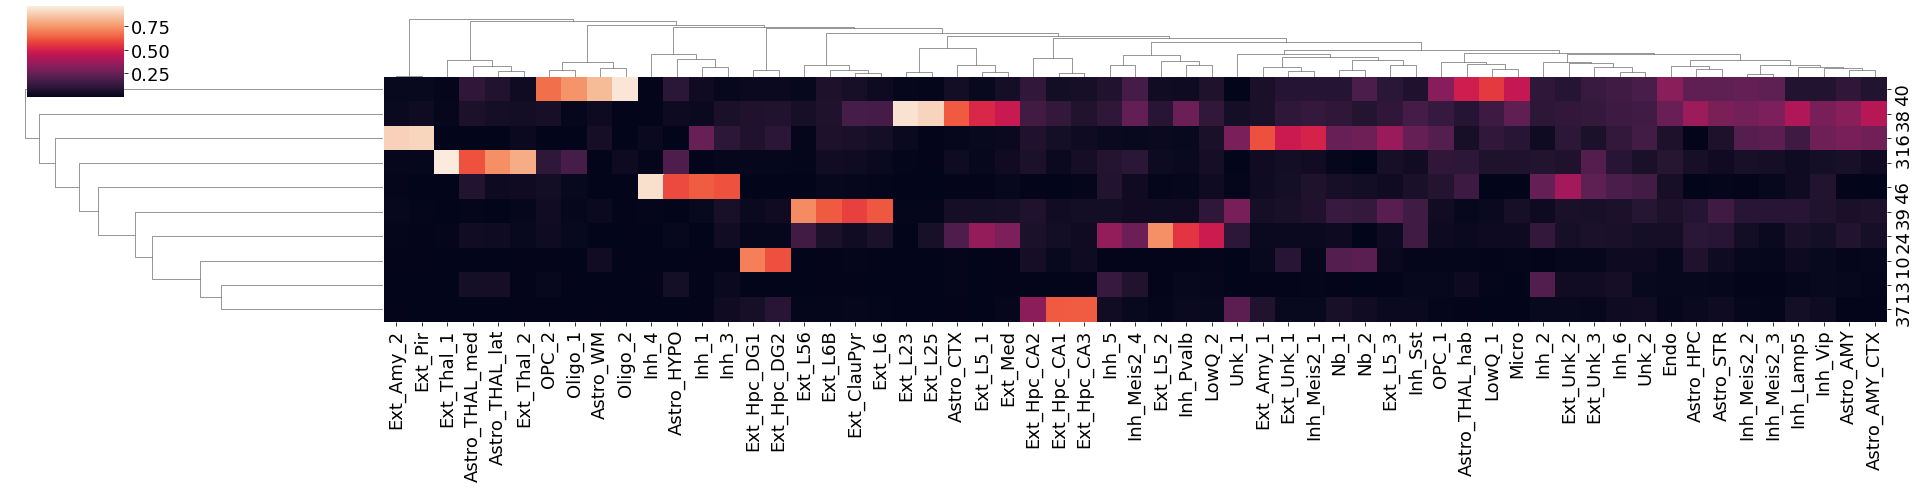

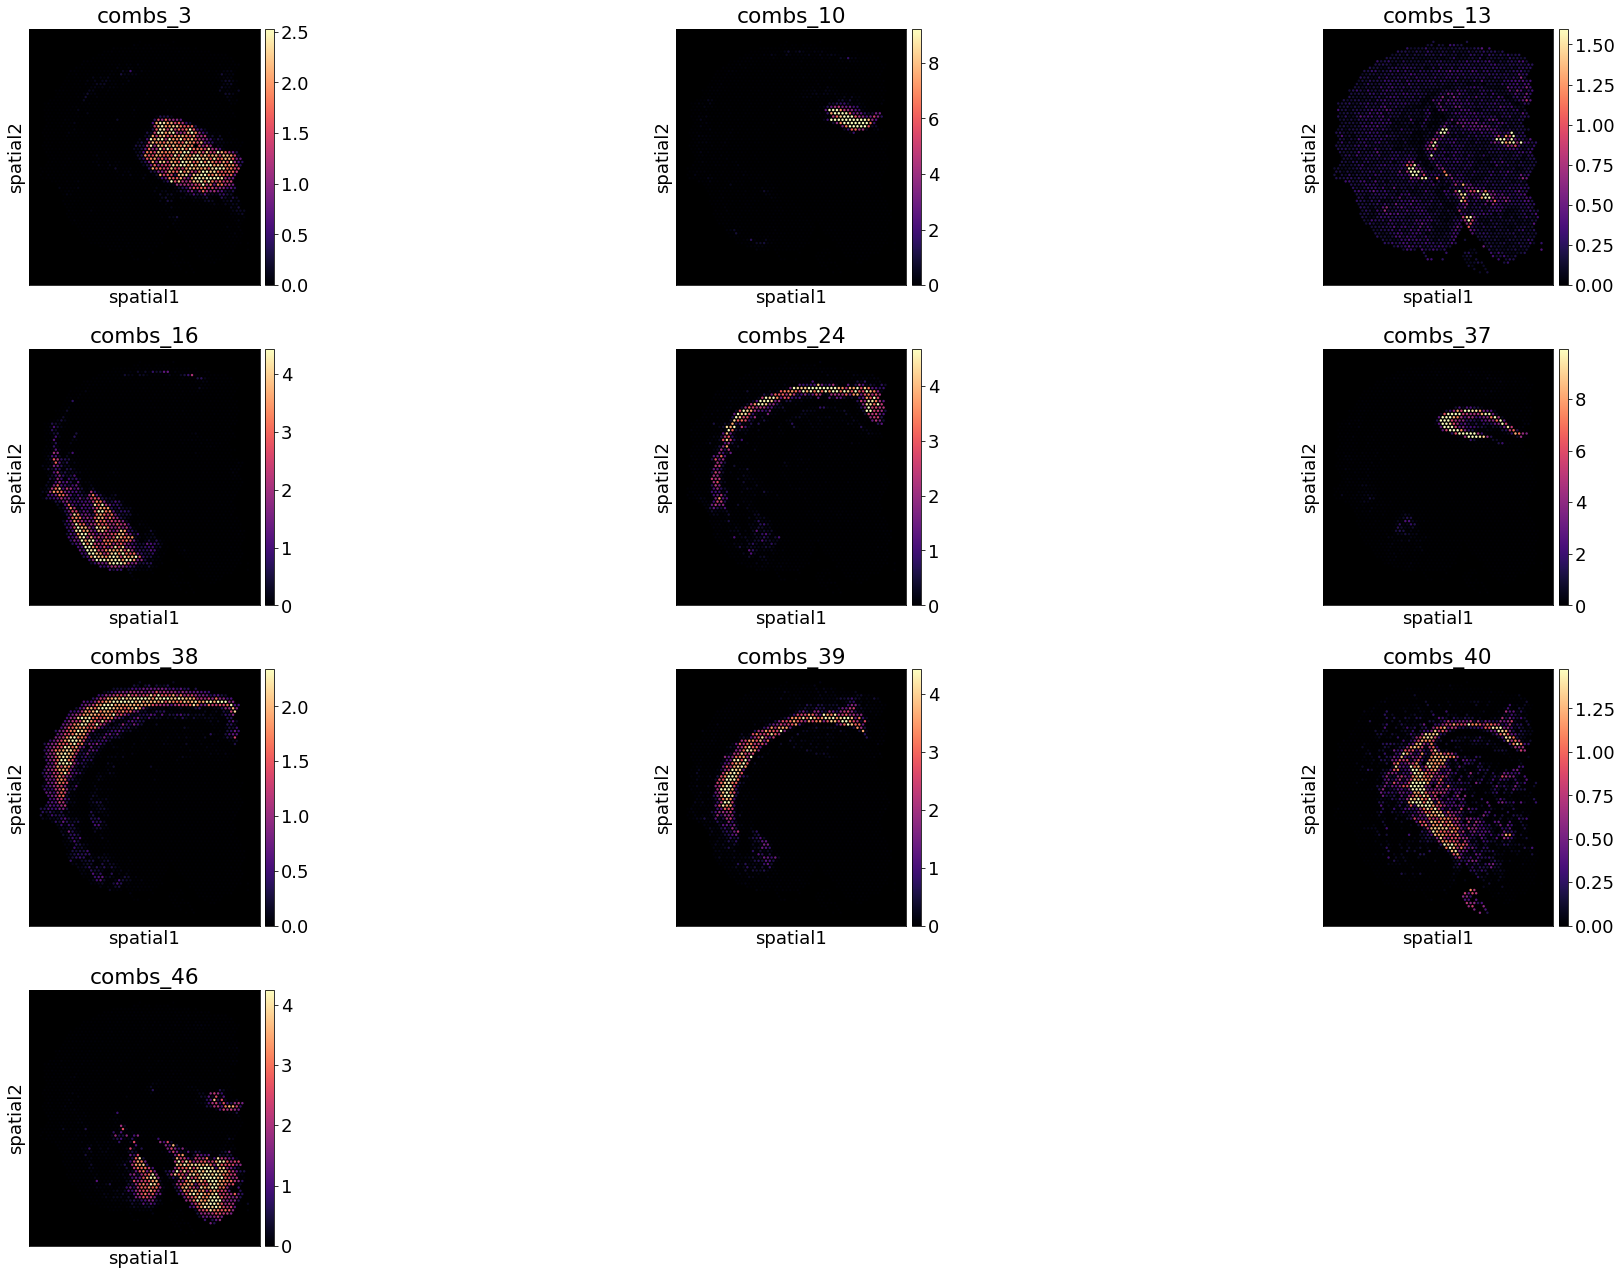

In [66]:
#from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['x_fr_group2fact'],
                            columns=adata_vis.uns['mod']['factor_names'])

rcParams["figure.figsize"] = [10, 5]
rcParams["axes.facecolor"] = "white"
plt.hist(np.log10(comb2fact_df.max(1)), bins=20);
thresh = 0.0249
plt.vlines(np.log10(thresh), 0, 10);
fact_filt = comb2fact_df.max(1) > thresh

comb2fact_df = comb2fact_df.loc[fact_filt.values, :]

clustermap(comb2fact_df, figsize=(27, 7))

comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df_prop, figsize=(27, 7))

n_combs = adata_vis.uns['mod']['post_sample_means']['z_sr_groups_factors'].shape[1]
combs_factors = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['z_sr_groups_factors'],
                             columns=[f'combs_{i}' for i in range(n_combs)],
                             index=adata_vis.uns['mod']['obs_names'])
combs_factors = combs_factors.loc[:, fact_filt.values]
adata_vis.obs[combs_factors.columns] = combs_factors

slide = select_slide(adata_vis, 'ST8059048')
crop_x, crop_y = get_crop_coord(slide)

s = 'spaceranger100_count_30458_ST8059048_mm10-3_0_0_premrna'
rcParams["axes.facecolor"] = "black"
sc.pl.spatial(slide, cmap='magma',
              color=combs_factors.columns, # limit size in this notebook
              library_id=f'{s}',
              ncols=3, 
              size=1, img_key='hires', 
              alpha_img=0,
              vmin=0, vmax='p99.0'
             )

### We also have nice correspondence of total cell abundance estimated by cell2location with nuclei count estimated by segmentation

In [67]:
# read in positions of segmented nuclei for each sample
adata_vis.obs['image_name_i'] = [i[41:-4] for i in adata_vis.obs['image_name']]

segm_res = {}
for i in adata_vis.obs['image_name_i'].unique():
    
    sample_name = adata_vis.obs.loc[adata_vis.obs['image_name_i'] == i,
                                    'sample'].unique()[0]
    
    res = pd.read_csv(results_folder + 'segmentation/' + i + '.csv')
    res['image_name_i'] = i
    res['sample_name'] = sample_name
    segm_res[i] = res
    
    
    # don't load images now to preserve RAM
    #path_segm = 'segmentation/color/' + i + '_color.jpg'
    #from cv2 import imread
    #full_img_segm = imread(path_segm, -1)
    
    #spatial_names = np.array(list(adata_vis.uns['spatial'].keys()))
    #spatial_name = spatial_names[[sample_name in i for i in spatial_names]][0]
    #adata_vis.uns['spatial'][spatial_name]['scalefactors']['tissue_lowres_scalef'] = 1
    #adata_vis.uns['spatial'][spatial_name]['images']['lowres'] = full_img_segm

segm_res = pd.concat(list(segm_res.values()), axis=0)

# filter segmented nuclei by size
segm_res = segm_res.loc[segm_res['size'] < 10**3.3,:]

def map_nuclei2spots(nuclei_df, adata, sample_ind, radius=None):
    
    from sklearn.neighbors import KDTree
    
    if radius is None:
        
        spatial_names = np.array(list(adata.uns['spatial'].keys()))
        spatial_name = spatial_names[[sample in i for i in spatial_names]][0]
        radius = adata.uns['spatial'][spatial_name]['scalefactors']['spot_diameter_fullres'] / 2
        
    # count nuclei within spots
    tree = KDTree(nuclei_df[['x', 'y']].values)

    adata.obs.loc[sample_ind, 'nuclei_count'] = tree.query_radius(adata.obsm['spatial'][sample_ind,:],
                                                                  radius, count_only=True)
    # measure averages size and std
    spotind = tree.query_radius(adata.obsm['spatial'][sample_ind,:], radius, count_only=False)
    adata.obs.loc[sample_ind, 'nuclei_size_sum'] = [nuclei_df['size'].values[spot].sum() for spot in spotind]
    adata.obs.loc[sample_ind, 'nuclei_size_mean'] = [nuclei_df['size'].values[spot].mean() for spot in spotind]
    adata.obs.loc[sample_ind, 'nuclei_size_std'] = [nuclei_df['size'].values[spot].std() for spot in spotind]
    
    
for s in adata_vis.obs['sample'].unique():
    
    spatial_names = np.array(list(adata_vis.uns['spatial'].keys()))
    spatial_name = spatial_names[[s in i for i in spatial_names]][0]
    
    map_nuclei2spots(segm_res.loc[segm_res['sample_name'].isin([str(s)]), :], 
                     adata_vis, adata_vis.obs['sample'].isin([s]), 
                     radius=adata_vis.uns['spatial'][spatial_name]['scalefactors']['spot_diameter_fullres'] / 2 * 1.1)

# compute total number of nuclei per section
segm_res['sample_name'].value_counts()

ST8059049    51300
ST8059048    48357
ST8059050    47831
ST8059052    46507
ST8059051    43680
Name: sample_name, dtype: int64

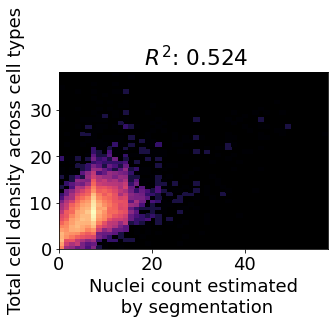

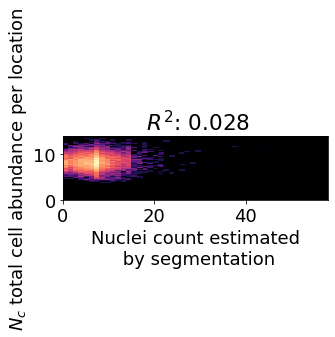

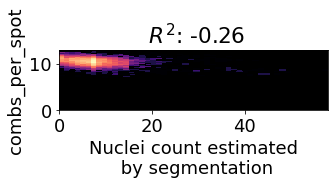

In [68]:
def plot_hist2d(x, y, x_lab, y_lab, title_prefix='',
                x_min=0, y_min=0, axis_equal=True):
    plt.hist2d(x, y, bins=50, cmap='magma',
               norm=matplotlib.colors.LogNorm(),
              );
    #plt.scatter(x, y);
    plt.xlabel(x_lab);
    plt.ylabel(y_lab);
    plt.xlim(x_min)
    plt.ylim(y_min)
    if axis_equal:
        plt.gca().set_aspect('equal', adjustable='box')
    
    from scipy.stats import spearmanr
    cor = np.corrcoef(x, y)[0, 1]
    cor, pval = spearmanr(x, y)
    plt.title(title_prefix + r' $R^2$: ' + str(np.round(cor,3)))


with matplotlib.rc_context({'figure.figsize': (5, 5)}):
    x = adata_vis.obs['nuclei_count'].values.flatten()
    y = adata_vis.uns['mod']['post_sample_q05']['w_sf'].sum(1).flatten()
    plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
                y_lab=r'Total cell density across cell types', 
                title_prefix='')
    plt.tight_layout()
    plt.show()
    
with matplotlib.rc_context({'figure.figsize': (5, 5)}):
    x = adata_vis.obs['nuclei_count'].values.flatten()
    y = adata_vis.uns['mod']['post_sample_q05']['n_s_cells_per_location'].flatten()
    plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
                y_lab=r'$N_c$ total cell abundance per location', 
                title_prefix='')
    plt.tight_layout()
    plt.show()
    
with matplotlib.rc_context({'figure.figsize': (5, 5)}):
    x = adata_vis.obs['nuclei_count'].values.flatten()
    y = adata_vis.uns['mod']['post_sample_q05']['y_s_groups_per_location'].flatten()
    plot_hist2d(x, y, x_lab='Nuclei count estimated\n by segmentation',
                y_lab=r'combs_per_spot', 
                title_prefix='')
    plt.tight_layout()
    plt.show()

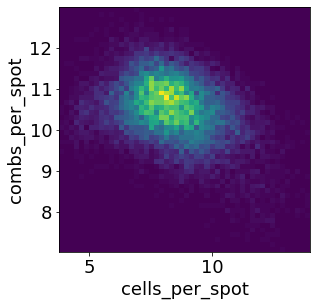

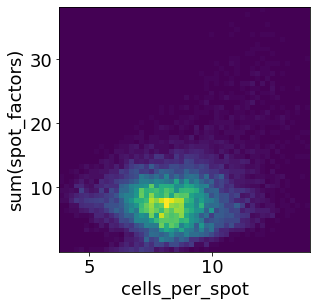

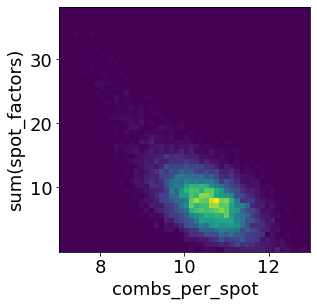

In [69]:
rcParams['figure.figsize'] = 4.5, 4.5
plt.hist2d(adata_vis.uns['mod']['post_sample_q05']['n_s_cells_per_location'].flatten(),
           adata_vis.uns['mod']['post_sample_q05']['y_s_groups_per_location'].flatten(),
           bins=50);
plt.xlabel('cells_per_spot');
plt.ylabel('combs_per_spot');
plt.show()

plt.hist2d(adata_vis.uns['mod']['post_sample_q05']['n_s_cells_per_location'].flatten(),
           adata_vis.uns['mod']['post_sample_q05']['w_sf'].sum(1).flatten(),
           bins=50);
plt.xlabel('cells_per_spot');
plt.ylabel('sum(spot_factors)');
plt.show()

plt.hist2d(adata_vis.uns['mod']['post_sample_q05']['y_s_groups_per_location'].flatten(),
           adata_vis.uns['mod']['post_sample_q05']['w_sf'].sum(1).flatten(),
           bins=50);
plt.xlabel('combs_per_spot');
plt.ylabel('sum(spot_factors)');
plt.show()

Modules and their versions used for this analysis

In [70]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.20.0
IPython.core.release 7.20.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.4
pexpect 4.8.0
ptyprocess 0.7.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.0
parso 0.8.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.9
scanpy 1.7.0
scanpy._metadata 1.7.0
packaging 20.9
packaging.__about__ 20.9
importlib_metadata 1.7.0
csv 1.0
_csv 1.0
numpy 1.20.0
numpy.core 1.20.0
numpy.core._multiarray_umath 3.1
numpy.lib 1.20.0
numpy.linalg.